# Time-related feature engineering

Strategies to leverage time-related features for a bike sharing demand regression task that is highly dependent on business cycles (days, weeks, months) and yearly seasonal cycles.

Introduce periodic feature engineering using `sklearn.preprocessing.SplineTransformer` and its `extrapolation='periodic'` option.

In [1]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

In [2]:
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0000,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0000,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0000,32.0
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0000,13.0
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1.0,12.0,19.0,False,1.0,True,misty,10.66,12.880,0.60,11.0014,119.0
17375,spring,1.0,12.0,20.0,False,1.0,True,misty,10.66,12.880,0.60,11.0014,89.0
17376,spring,1.0,12.0,21.0,False,1.0,True,clear,10.66,12.880,0.60,11.0014,90.0
17377,spring,1.0,12.0,22.0,False,1.0,True,clear,10.66,13.635,0.56,8.9981,61.0


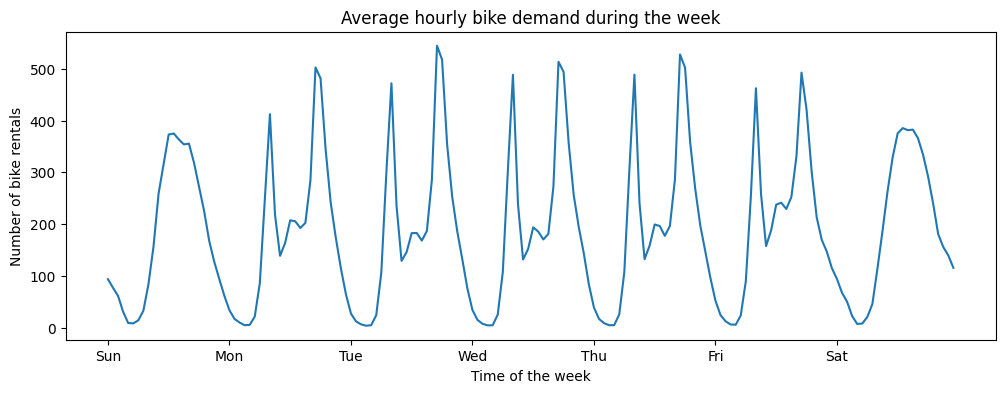

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df[["weekday", "hour", "count"]].groupby(["weekday", "hour"]).mean()["count"]
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [4]:
df["count"].max()

977.0

Rescale the target variable (number of hourly bike rentals) to predict the relative demand, making the mean absolute error more easily interpretable as the fraction of the maximum demand.

In [5]:
y = df["count"] / df["count"].max()

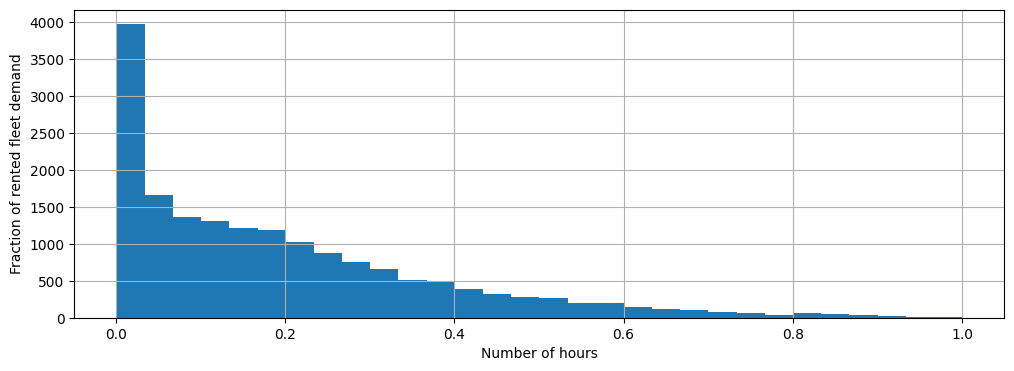

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))

y.hist(bins=30, ax=ax)
_ = ax.set(
    ylabel="Fraction of rented fleet demand",
    xlabel="Number of hours",
)

The input feature data is a time-annotated hourly log of variables describing weather conditions. It includes both numerical and categorical variables. Note also that time has already been expanded into several complementary columns.

In [7]:
X = df.drop("count", axis=1)
X

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0000
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0000
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0000
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0000
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1.0,12.0,19.0,False,1.0,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1.0,12.0,20.0,False,1.0,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1.0,12.0,21.0,False,1.0,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1.0,12.0,22.0,False,1.0,True,clear,10.66,13.635,0.56,8.9981


> **Tip**:
> If you only have a date / DateTime column, you can expand it into hour-in-the-day, day-in-the-week, day-in-the-month, etc. using `pandas`: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components

In [8]:
X["weather"].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

In [9]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

In [10]:
X["weather"].value_counts()

clear    11413
misty     4544
rain      1422
Name: weather, dtype: int64

In [11]:
X["season"].value_counts()

fall      4496
summer    4409
spring    4242
winter    4232
Name: season, dtype: int64

## Time-based cross-validation

Since the dataset is a time-ordered event log (hourly demand), we will use a time-sensitive cross-validation splitter to evaluate our demand forecasting model as realistically as possible. We use a gap of 2 days between the train and test side of the splits. We also limit the training set size to make the performance of CV folds more stable.

1000 test datapoints should be enough to quantify the performance of the model. This represents a bit less than 1.5 months of continuous test data.

In [12]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=10_000,
    test_size=1_000,
    gap=48,
)

In [13]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [14]:
X.iloc[test_0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
12379,summer,1.0,6.0,0.0,False,2.0,True,clear,22.14,25.760,0.68,27.9993
12380,summer,1.0,6.0,1.0,False,2.0,True,misty,21.32,25.000,0.77,22.0028
12381,summer,1.0,6.0,2.0,False,2.0,True,rain,21.32,25.000,0.72,19.9995
12382,summer,1.0,6.0,3.0,False,2.0,True,rain,20.50,24.240,0.82,12.9980
12383,summer,1.0,6.0,4.0,False,2.0,True,rain,20.50,24.240,0.82,12.9980
...,...,...,...,...,...,...,...,...,...,...,...,...
13374,fall,1.0,7.0,11.0,False,1.0,True,clear,34.44,40.150,0.53,15.0013
13375,fall,1.0,7.0,12.0,False,1.0,True,clear,34.44,39.395,0.49,8.9981
13376,fall,1.0,7.0,13.0,False,1.0,True,clear,34.44,39.395,0.49,19.0012
13377,fall,1.0,7.0,14.0,False,1.0,True,clear,36.08,40.910,0.42,7.0015


In [15]:
X.iloc[train_0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
2331,summer,0.0,4.0,1.0,False,2.0,True,misty,25.42,31.060,0.50,6.0032
2332,summer,0.0,4.0,2.0,False,2.0,True,misty,24.60,31.060,0.53,8.9981
2333,summer,0.0,4.0,3.0,False,2.0,True,misty,23.78,27.275,0.56,8.9981
2334,summer,0.0,4.0,4.0,False,2.0,True,misty,22.96,26.515,0.64,8.9981
2335,summer,0.0,4.0,5.0,False,2.0,True,misty,22.14,25.760,0.68,8.9981
...,...,...,...,...,...,...,...,...,...,...,...,...
12326,summer,1.0,6.0,19.0,False,6.0,False,clear,26.24,31.060,0.36,11.0014
12327,summer,1.0,6.0,20.0,False,6.0,False,clear,25.42,31.060,0.35,19.0012
12328,summer,1.0,6.0,21.0,False,6.0,False,clear,24.60,31.060,0.40,7.0015
12329,summer,1.0,6.0,22.0,False,6.0,False,clear,23.78,27.275,0.46,8.9981


## Gradient Boosting

Gradient Boosting Regression with decision trees is often flexible enough to efficiently handle heterogenous tabular data with a mix of categorical and numerical features so long as the number of samples is large enough.

Here, we do a minimal ordinal encoding for the categorical variables and then let the model know that it should treat those as categorical variables by using a dedicated tree-splitting rule. Since we use an ordinal encoder, we pass the list of categorical values explicitly to use a logical order when encoding the categories as integers instead of the lexicographical order. This also has the added benefit of preventing any issue with unknown categories when using cross-validation.

The numerical features need no preprocessing. For the sake of simplicity, we only try the default hyperparameters for this model.

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

categorical_columns = ["weather", "season", "holiday", "workingday"]

categories = [
    ("clear", "misty", "rain"),
    ("spring", "summer", "fall", "winter"),
    ("False", "True"),
    ("False", "True"),
]

ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(
        loss="squared_error",
        categorical_features=range(4),
    ),
)

In [17]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )

    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]

    print(
        f"Mean Absolute Error: {mae.mean():.3f} ± {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} ± {mae.std():.3f}"
    )

In [18]:
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.044 ± 0.003
Root Mean Squared Error: 0.068 ± 0.003


We can interpret the average error as being within 4-6% of the maximum demand. This seems pretty good considering we did not apply any hyperparameter tuning.

Also note that we currently passed in the time-related features (year, month, hour) with no additional preprocessing.

Let's compare how these behave in a more-naïve linear model.

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
import numpy as np

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)

naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [20]:
evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.142 ± 0.014
Root Mean Squared Error: 0.184 ± 0.014


Performance is pretty bad. The average error is within ~14% of the maximum demand. This is more than three times higher than the average error on the gradient boosting regressor. We can suspect that the naive ordinal encoding (merely min-max scaled) of the periodic time-related features might prevent the linear regression model from properly leveraging the time information: linear regression does not automatically model non-monotonic relationships between the input features and the target. Non-linear terms have to be engineered in the input.

For example, the raw numerical encoding of the "hour" feature prevents the linear model from recognizing that an increase of hour in the morning from 6 to 8 should have a strong positive impact on the number of bike rentals while an increase of similar magnitude in the evening from 18 to 20 should have a strong negative impact on the predicted number of bike rentals.

## Time-steps as categories

Since the time features are encoded in a discrete manner using integers (24 unique values in the "hours" column), we might decide to treat those as categorical variables using a one-hot encoding and thereby ignore any assumption implied by the ordering of the hour values.

Using one-hot encoding for the time features gives the linear model a lot more flexibility as we introduce one additional feature per discrete time level.

In [21]:
one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [22]:
evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.099 ± 0.011
Root Mean Squared Error: 0.131 ± 0.011


Our error rate is now around 10%. It's better than the ordinal encoding of the time features. However, this introduced a large number of new features. If the time of day was represented in minutes since the start of the day instead of hours, one-hot encoding would have introduced 1440 features instead of 24. We might apply a `KBinsDiscretizer`, or we might observe that one-hot encoding completely ignores the ordering of the hour levels. This might be an interesting inductive bias to preserve.

Here we'll investigate smooth, non-monotonic encodings that locally preserve the relative ordering of time features.

## Trigonometric Features

**Idea 1**: try encoding each of the periodic features using a $\sin$ and $\cos$ transformation with the matching period.

Each ordinal time feature is transformed into two features that together encode equivalent information in a non-monotonic way, and more importantly without any jump between the first and the last value of the periodic range.

In [23]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

Let's visualize this on some synthetic hour data with a bit of extrapolation beyond hour 23.

In [24]:
import pandas as pd

hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["hour"],
)

hour_df

,hour
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [25]:
hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]
hour_df

,hour,hour_sin,hour_cos
0,0,0.000000e+00,1.000000e+00
1,1,2.588190e-01,9.659258e-01
2,2,5.000000e-01,8.660254e-01
3,3,7.071068e-01,7.071068e-01
4,4,8.660254e-01,5.000000e-01
5,5,9.659258e-01,2.588190e-01
6,6,1.000000e+00,6.123234e-17
7,7,9.659258e-01,-2.588190e-01
8,8,8.660254e-01,-5.000000e-01
9,9,7.071068e-01,-7.071068e-01


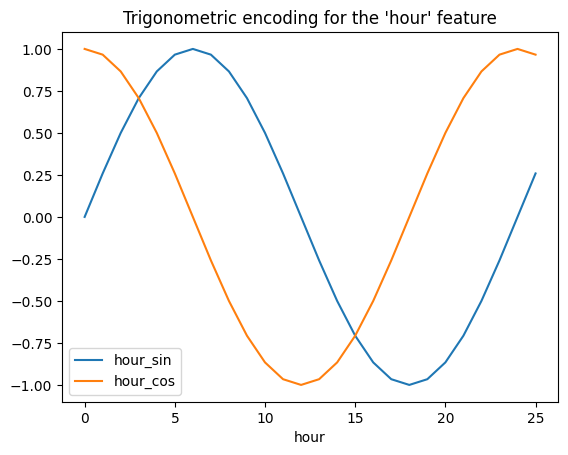

In [26]:
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

A 2D scatter plot with the hours encoded as colors might better help us see how this representation maps the 24 hours of the day into a 2D space, similar to some 24 hour version of an analog clock. Note that the "25th" hour is mapped back to the 1st hour because of the periodic nature of the $\sin$ and $\cos$ representation.

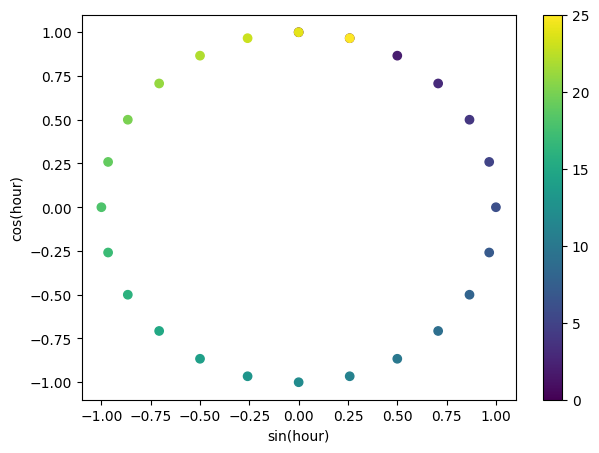

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(xlabel="sin(hour)", ylabel="cos(hour)")
_ = fig.colorbar(sp)

We now have all the tools we need to build a pipeline accounting for this strategy:

In [28]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)

In [29]:
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.125 ± 0.014
Root Mean Squared Error: 0.166 ± 0.014


Uh oh. Performance got worse.

Let's revisit this at the end.

## Periodic spline features

We can try an alternative encoding of the periodic time-related features using spline transformations with a large enough number of splines, and as a result a larger number of expanded features compared to the sine/cosine transformation:

In [30]:
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

Again, let's visualize the effect of this feature expansion on some synthetic hour data with a bit of extrapolation beyond hour 23.

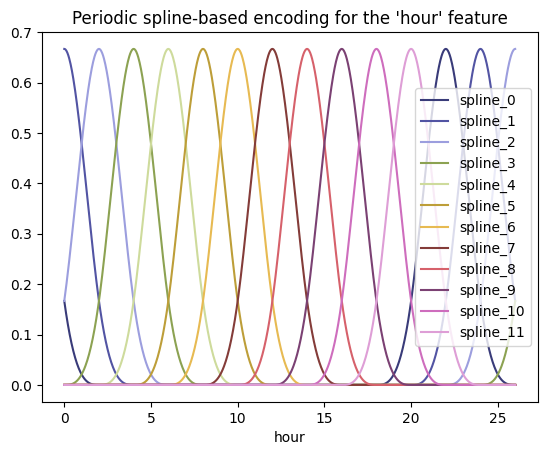

In [31]:
hour_df = pd.DataFrame({"hour": np.linspace(0, 26, 1000)})

splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)

splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)

pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.tab20b)
_ = plt.title("Periodic spline-based encoding for the 'hour' feature")

Notice that thanks to the `extrapolation="periodic"` parameter, the feature encoding stays smooth when extrapolating beyond midnight.

We can now build a predictive pipeline using this alternative periodic feature engineering strategy.

It is possible to use fewer splines than discrete levels for those ordinal values. This makes spline-based encoding more efficient than one-hot encoding while preserving most of the expressivity:

In [32]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)

In [33]:
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.097 ± 0.011
Root Mean Squared Error: 0.132 ± 0.011


So spline features make it possible for the linear model to leverage the periodic time-related features and reduce the error from ~14% to ~10%—putting it in line with what we observed in the one-hot encoded feature case.

## Qualitative analysis of the impact of features on linear model predictions

Let's visualize the impact of our feature engineering choices on the time-related shape of the predictions.

To do so, we apply an arbitrary time-based split to compare the predictions on a range of held-out data points.

In [34]:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])

one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])

cyclic_cossin_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_0])

cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_0])

gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

Visualize predictions by focusing on the last 94 hours (4 days) of the test set to get some qualitative insights:

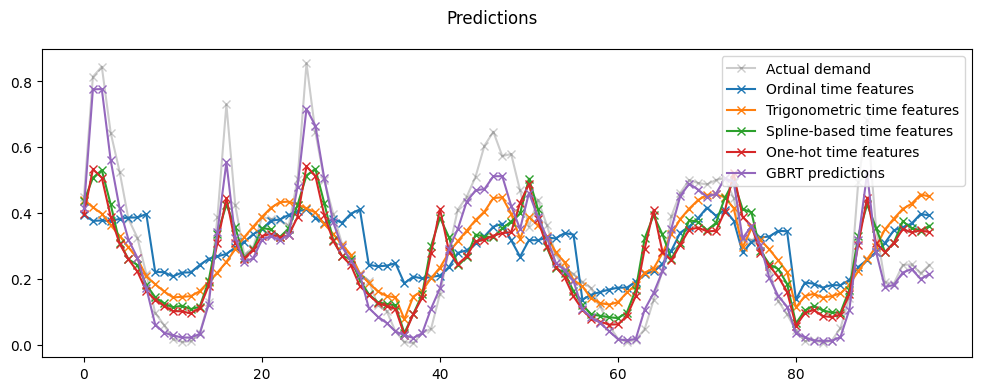

In [35]:
last_hours = slice(-96, None)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions")

ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(naive_linear_predictions[last_hours], "x-", label="Ordinal time features")
ax.plot(
    cyclic_cossin_linear_predictions[last_hours],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_hours],
    "x-",
    label="Spline-based time features",
)
ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features",
)
ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="GBRT predictions"
)
_ = ax.legend()

A few observations.

- The **Ordinal time features** exhibit an odd behavior where they slowly increase, then drop back down again. They do not capture the natural periodicity of this problem, but instead show a large "jump" at the beginning of the day when the hour goes from 23 back to 0. Something similar will likely happen at the end of weeks or years.
- The **Trigonometric time features** do appear to capture some daily variation (but in my opinion also appear to be overly smooth). They lack the discontinuities that the ordinal features had, but linear regression still fails to leverage them to properly model intra-day variations. Using trigonometric features for higher harmonics or additional trigonometric features for the natural period with different phases might fix this.
- The **Spline-based time features** fix two problems: they give more expressivity to the linear model by making it possible to focus on specific hours thanks to the use of 12 splines. Furthermore, the `extrapolation='periodic'` option enforces a smooth representation between hours 23 and 0.
- The **One-hot time features** appear close to the spline features, but seem more "spiky." They may better model the morning peak during the week days since this peak is shorter than one hour. However, we will see in the following that what can be an advantage for linear models is not necessarily one for more expressive models.

While we're here, we should compare the number of features extracted in each feature engineering pipeline:

In [39]:
naive_linear_pipeline[:-1].transform(X).shape

(17379, 19)

In [40]:
one_hot_linear_pipeline[:-1].transform(X).shape

(17379, 59)

In [41]:
cyclic_cossin_linear_pipeline[:-1].transform(X).shape

(17379, 22)

In [42]:
cyclic_spline_linear_pipeline[:-1].transform(X).shape

(17379, 37)

This confirms that the one-hot encoding and the spline encoding strategies create a lot more features for the time representation than the alternatives, which in turn gives the downstream linear model more flexibility (degrees of freedom) to avoid underfitting.

Finally, we observe that none of the linear models can approximate the true bike rentals demand, especially for the peaks that can be quite sharp at rush hours during the working days but much flatter during the week-ends: the most accurate linear models based on splines or one-hot encoding tend to forecast peaks of commuting-related bike rentals even on the week-ends and under-estimate the commuting-related events during the working days.

These systematic prediction errors reveal a form of under-fitting and can be explained by the lack of interaction terms between features, e.g. "working day" and features derived from "hours." This issue will be addressed in the following sections.

## Modeling pairwise interactions between splines and polynomial features

Linear models do not automatically capture interaction effects between input features. It does not help that some features are marginally non-linear in the case with features constructed by `SplineTransformer` (or one-hot encoding or binning).

However, it is possible to use the `PolynomialFeatures` class on coarse grained spline encoded hours to model the "workingday" / "hours" interaction explicitly without introducing too many new variables:

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion

hour_workday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("workingday", FunctionTransformer(lambda x: x == "True"), ["workingday"],)
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

Those features are then combined with the ones already computed in the previous spline-based pipeline. We can observe a nice performance improvement by modeling this pairwise interaction explicitly:

In [45]:
cyclic_spline_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions", hour_workday_interaction),
        ]
    ),
    RidgeCV(alphas=alphas),
)

In [46]:
evaluate(cyclic_spline_interactions_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.078 ± 0.009
Root Mean Squared Error: 0.104 ± 0.009


## Modeling non-linear feature interactions with kernels

The previous analysis highlighted the need to model the interactions between "workingday" and "hours". Another example of a non-linear interaction that we would like to model could be the impact of the rain that might not be the same during the working days, week-ends, and holidays.

To model all such interactions, we could either use a polynomial expansion on all marginal features at once, after their spline-based expansion. However, this would create a quadratic number of features which can cause overfitting and computational tractability issues.

An alternative is to use the Nyström method to compute an approximate polynomial kernel expansion:

In [47]:
from sklearn.kernel_approximation import Nystroem

cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)

In [49]:
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.053 ± 0.002
Root Mean Squared Error: 0.076 ± 0.002


Neat. We found something that almost rivals the performance of the gradient boosted trees with an average error around 5% the maximum demand.

Note that the final step of this pipeline is a linear regression model, the intermediate steps such as the spline feature extraction and the Nyström kernel approximation are highly non-linear. As a result, the compound pipeline is much more expensive than a simple linear regression model with raw features.

For the sake of completeness, we can also evaluate the combination of one-hot-encoding and kernel approximation:

In [50]:
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)

In [51]:
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error: 0.082 ± 0.006
Root Mean Squared Error: 0.111 ± 0.006


While the one-hot encoded features were competitive with spline-based features when using linear models, this is no longer the case when using a low-rank approximation of a non-linear kernel: this can be explained by the fact that spline features are smoother and allow the kernel approximation to find a more expressive decision function.

Let us now have a qualitative look at the predictions of the kernel models and of the gradient boosted trees that should be able to better model non-linear interactions between features:

In [53]:
one_hot_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[test_0])

cyclic_spline_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_0])

We will zoom on the last four days of the test set:

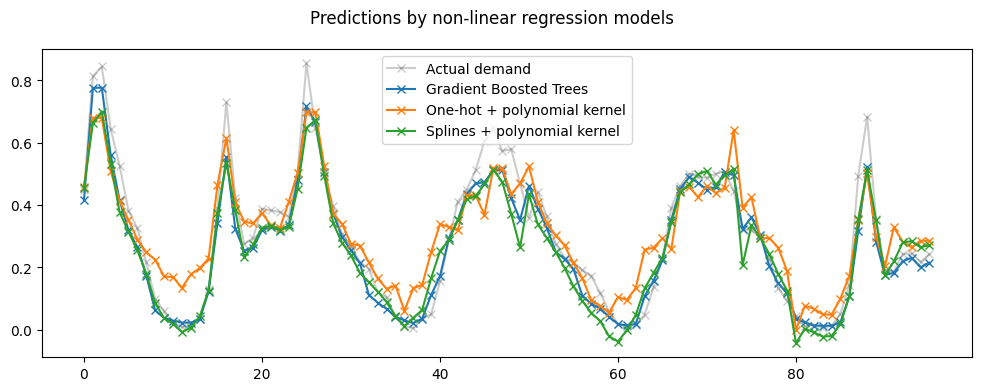

In [54]:
last_hours = slice(-96, None)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="Gradient Boosted Trees",
)
ax.plot(
    one_hot_poly_predictions[last_hours],
    "x-",
    label="One-hot + polynomial kernel",
)
ax.plot(
    cyclic_spline_poly_predictions[last_hours],
    "x-",
    label="Splines + polynomial kernel",
)
_ = ax.legend()

A few more observations:

1. Note that trees can naturally model non-linear feature interactions since, by default, decision trees are allowed to grow beyond a depth of 2 levels.
2. We can observe that the combination of spline features and non-linear kernels works quite well with the low rank kernel model. In particular, they significantly over-estimate the low demand hours more than competing models.
3. None of the models can successfully predict some of the peak rentals at the rush hours during the working days. It is possible that access to additional features would be required to further improve the accuracy of the predictions. For instance, it could be useful to have access to the geographical repartition of the fleet at any point in time or the fraction of bikes that are immobilized because they need servicing.

Let us finally get a more quantitative look at the prediction errors of these three models using the true vs. predicted demand scatter plots:

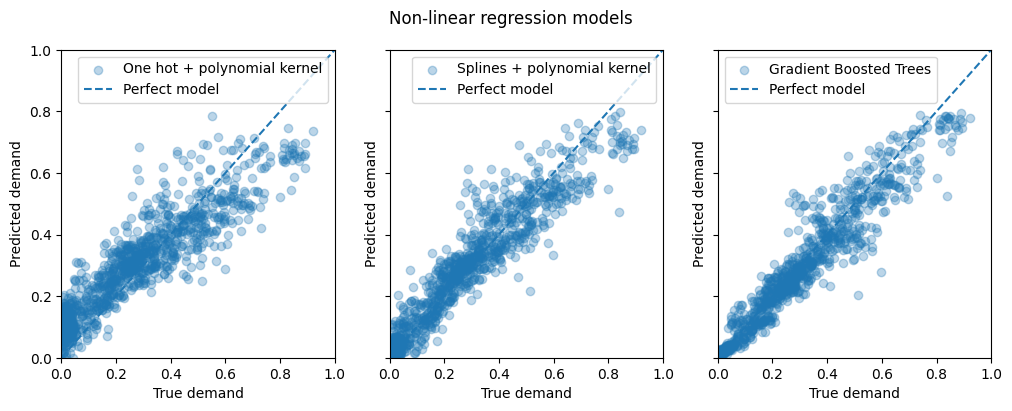

In [55]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    one_hot_poly_predictions,
    cyclic_spline_poly_predictions,
    gbrt_predictions,
]
labels = [
    "One hot + polynomial kernel",
    "Splines + polynomial kernel",
    "Gradient Boosted Trees",
]

for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

This visualization confirms the conclusions we draw in the previous plot.

All models under-estimate the high demand events (working day rush hours), but gradient boosting a bit less so. The low demand events are well predicted on average by gradient boosting while the one-hot polynomial regression pipeline seems to systematically over-estimate demand in that regime. Overall the predictions of the gradient boosted trees are closer to the diagonal than for the kernel models.

## Conclusion

We note that we could have obtained slightly better results for kernel models by using more components (higher rank kernel approximation) at the cost of longer fit and prediction durations. For larger values of `n_components`, the performance of one-hot encoded features would even match the spline features.

The `Nystroem` + `RidgeCV` regressor could have been replaced by `MLPRegressor` with one or two hidden layers and we would have obtained quite similar results.

The dataset we used in this case study is sampled on a hourly basis. However cyclic spline-based features could model time-within-day or time-within-week very efficiently with finer-grained time resolutions (for instance with measurements taken every minute instead of every hours) without introducing more features. One-hot encoding time representations would not offer this flexibility.

Finally, in this notebook we used `RidgeCV` because it is very efficient from a computational point of view. However, it models the target variable as a Gaussian random variable with constant variance. For positive regression problems, it is likely that using a Poisson or Gamma distribution would make more sense. This could be achieved by using `GridSearchCV(TweedieRegressor(power=2), param_grid({"alpha": alphas}))` instead of RidgeCV.
